No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


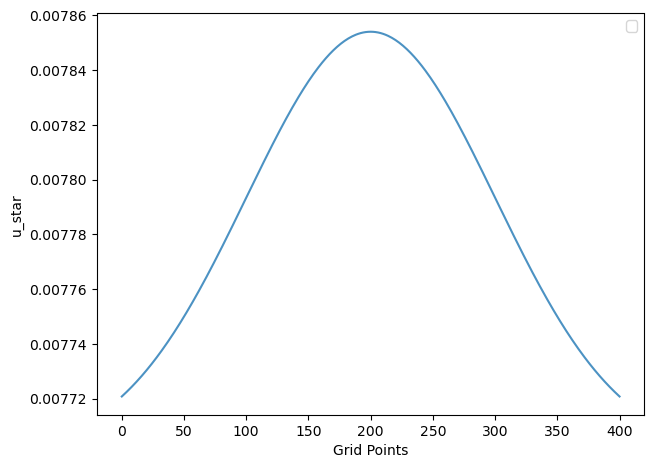

In [34]:
import math as mt
import numpy as np
from Plots.Velocity_plot import Graph_V,plot_V
import matplotlib.pyplot as plt

dia=0.0154
length=2
Grid_points=200
H=dia/100
W=length/4
dx=length/Grid_points
r_effective=np.zeros((2*Grid_points+1))

for i in range(0,2*Grid_points+1):
    z= (length/2)-(i*dx/2)
    r_effective[i]=(dia/2)+(H*mt.exp(-z**2/(2*(W**2))))

graph_v=Graph_V()
x2=np.arange(len(r_effective))
plot_V(r_effective,x2,graph_v)

In [ ]:
import numpy as np
import os
import time 
import math as mt
import matplotlib.pyplot as plt
from Modules.Momentum import Momentum
from Modules.Pressure import Pressure_adjust
from Update.Pressure_update import add
from Modules.convergence import convergence
from Modules.Pressure import Pressure_adjust
#from Plots.Pressure_plot import plot_pressure
from Plots.Plot import Graph_PV,plot
from Plots.Velocity_plot import Graph_V,plot_V
from Plots.Pressure_plot import  Graph_P,plot_P 
from Plots.Area_profile import Graph_Area_profile,plot_Area
from Modules.Correct_velocity import Correct_velocity
from Modules.Correct_pressure import Correct_pressure
from Area.linear_area import Linear_area_profile, Const_area_profile,Area
"""
const paramers through-out the analysis
All units are taken in SI system (Kilogram,Meter,Second)

"""
Total_time=1
#dt = 0.001                              # Time step size                 # Number of time steps

rho = 996.550                          # Density kg/m3
g = 9.8                                # Gravitational acceleration m/s2
Grid_points=500                #Total number of grid points (Cell centres including extra cell at the end)
Inletmassflux=900                      #kg/m2.s
P_atm=1                                #atm
dia=0.0154                             #m
d_vis=0.000854                         #Ns/m2
p_exit= P_atm* 101325                  #N/m2
A= (mt.pi)*(dia**2)/4                  #m2
u_inlet= Inletmassflux/(rho)           #m/s
length=2                               #m
dx = length/Grid_points 
dt=0.0040             # Spatial grid size
#n = int(Total_time/dt)
n=1  
CFL=u_inlet*dt/dx
minimum_dt=dx/u_inlet     #<0.0044


"""
Variables evolve-with time

graph=Graph_PV()
a1=np.arange(0,len(A_n))
a2=np.arange(0,len(r_x))
plot(A_n,r_x,a1,a2,graph)
plt.pause(0.5)
plt.show()

graph=Graph_Area_profile()
x=np.arange(0,len(r_x1))
plot_Area(x,r_x1,r_x2,A_n,p_s,graph)
plt.pause(0.5)
plt.show()







"""
# Initialize arrays for velocity (u) and pressure (p) at staggered grid locations
#A_n = np.full((2 * Grid_points + 1), A)                # Area at n_th step
#perimeter= (mt.pi)*dia                                 #perimeter at n_th step 
#p_s=np.full((2 * Grid_points + 1), perimeter)
l1=length/4
l2=3*length/4
r_x1,r_x2,A_n,p_s=Area(dia,Grid_points,length,l1,l2)   #Area and perimeter at n_th step     
dp= 128*d_vis*length*A*u_inlet/((mt.pi)*dia**4)        #pressure change for end points(Change the length to get the desired pressure drop)
print(dp,"dp")


"""
Initialize the velocity 
"""
u_n = np.zeros(Grid_points+1)  
u_n[0]=u_inlet
for i in range(1,len(u_n)):
    u_n[i]=0.01    


# Main Algo
def unsteady_1D_flow(A_n,u_n,p_s,Grid_points,rho,dx,dt,d_vis,n,u_inlet,p_exit):
    p_star = np.zeros(Grid_points)
    u_star = np.zeros(Grid_points+1) 
    x1=np.arange(0,len(p_star))
    x2=np.arange(0,len(u_star))

    """
    Initialize the pressure 
    """
    p_star[len(p_star)-1]=p_exit
    for i in range(len(p_star)-2,-1,-1):
        #p_star[i]=p_star[i+1]+((dp*dx)/length)
        p_star[i]=p_star[i+1]
    
    u_star=u_n
    #Area=np.full((2 * Grid_points + 1), A)
    Area=np.ones((2 * Grid_points + 1))
    Area=A_n
    for t in range(0,n):
        graph=Graph_PV()
        #graph_v=Graph_V()
        #graph_p=Graph_P()
        start_time=time.time()
        #plot_V(u_star,x2,graph_v)
        #plt.pause(0.1)
        #plot_P(x1,p_star,graph_p)
        #plt.pause(0.1)
        #plot(p_star,u_star,x1,x2,graph)
        #plt.pause(0.5)
        i=0
        u_star=Momentum(p_star,u_n,u_star,Grid_points,rho,dt,dx,d_vis,A_n,Area,p_s,u_inlet,p_exit) 
        while True:
            i=i+1
            print(i)
            plot(p_star,u_star,x1,x2,graph)
            plt.pause(1)
            converge=convergence(u_star,Grid_points,rho,Area,A_n,dx,dt)
            print(converge,"converge")
            if converge<10**-4:
                break                                                                         
            p_add=Pressure_adjust(u_star,Grid_points,u_n,Area,A_n,p_s,rho,dx,dt,d_vis,u_inlet,p_exit)
            relaxation_factor=0.5
            p_add=relaxation_factor*p_add
            #p_star=add(p_add,p_star,relaxation_factor)
            u_star=Correct_velocity(u_star,p_add,Grid_points,rho,dt,dx,d_vis,A_n,Area,u_n,p_s)
            p_star=Correct_pressure(p_star,u_n,u_star,Grid_points,rho,dt,dx,d_vis,A_n,Area,p_s)
            #relaxation_factor=10**-5
            #p_star=add(p_add,p_star,relaxation_factor)
            #plot_P(x1,p_star,graph_p)
            #plt.pause(0.5)
            #u_star=Momentum(p_star,u_n,u_star,Grid_points,rho,dt,dx,d_vis,A_n,Area,p_s,u_inlet,p_exit)
            #plot_P(x1,p_star,graph_p)
            #plt.pause(0.5)
            #u_star=u_update
            #plot_V(u_update,x2,graph_v)
            #plt.pause(0.1)
            elasp_time = time.time() - start_time
            if elasp_time>100:
                break
            # Save the current figure with a unique file name
            # # Unique file name based on iteration
            #plt.savefig(file_name)
        
            #plt.clf()  # Clear the current figure to prepare for the next iteration
         
        #print(p_update[0],"p_update")
        #print(p_star[0],"p_star")
        #plot_P(x1,p_update,graph_p)
        #plt.pause(0.05)   
        u_n=u_star   
    plt.show()    
    return u_star,p_star


"""
Final result 
"""

velocity, Pressure =unsteady_1D_flow(A_n,u_n,p_s,Grid_points,rho,dx,dt,d_vis,n,u_inlet,p_exit)
